# Viable Edu Coding and Data Analysis

_The objective of this task is to do the following:_
1. Scrape the web using a Chrome driver in order to compile LinkedIn profiles connected to a specific company
2. Convert this data into csv files
3. Read these csv files using a dataframe package (either pandas or turicreate)
4. Build a classifier to identify users based on profile information
5. Modify dataframes with new information
6. Build visual keys to enable us to better analyze this data. These visual keys include histograms, scatterplots, etc.
7. Derive business insights from these visualized data metrics on the efficacy of ViableEdu's social media presence.

_Our initial hypothesis is that ViableEdu's initial user base represents a recursive loop that lacks substantial external penetration. The alternate hypothesis is that ViableEdu is reaching a substantial user base beyond its initial followers._

_The Business Intelligence insights we seek to answer are the following:_
1. What is our target demographic?
2. Are we reaching our target demographic?
3. What other clusters are we reaching?
4. How successful is our social media team at present?
5. What actionable steps can we take to improve the numbers among specific segments in our core demographic?

# Step 1: Scrapping ViableEDU's Linkedin

We want to know who is interacting with viableEDU:
* People reacting to content posted
* Information about people interacting with the posts 
* List of followers

Sources:
* https://selenium-python.readthedocs.io/
* https://github.com/austinoboyle/scrape-linkedin-selenium

## Import Key Modules

In [ ]:
# Libraries
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import time
import numpy as np
import pandas as pd
import re
import math as mt
from datetime import datetime
import pickle

## Preliminary Setup

In [ ]:
# Initialize Selenium
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(executable_path='ChromeDriver/chromedriver.exe',options=options)

In [ ]:
# Login into Linkedin
url = 'https://www.linkedin.com/login'
driver.get(url)

# Locate the elements to be filled
user = driver.find_element_by_id("username")
user.clear()
pswd = driver.find_element_by_id("password")
pswd.clear()

# Introduce your credentials
user.send_keys("")
pswd.send_keys("")
pswd.send_keys(Keys.RETURN)

## Scrapping ViableEDU Linkedin

In [ ]:
# Scrapping ViableEDU Linkedin
url2 = 'https://www.linkedin.com/company/viableedu/'
driver.get(url2)

# Scroll down the page until it reachs the end
webElem = driver.find_element_by_tag_name('html')
i = 0
while (i < 35):
    time.sleep(0.5)
    webElem.send_keys(Keys.PAGE_DOWN)
    i = i + 1

In [ ]:
# Scroll up the page until it reachs the beggining
webElem = driver.find_element_by_tag_name('html')
i = 0
while (i < 35):
    time.sleep(0.5)
    webElem.send_keys(Keys.PAGE_UP)
    i = i + 1

In [ ]:
# Close the chat window
chat = driver.find_elements_by_class_name('msg-overlay-bubble-header__control.msg-overlay-bubble-header__control--new-convo-btn.artdeco-button.artdeco-button--circle.artdeco-button--muted.artdeco-button--1.artdeco-button--tertiary.ember-view')
chat[1].click()

### List of posts made by ViableEDU

In [ ]:
# Get info from all the posts
postsList = driver.find_element_by_class_name('org-updates__core-rail.core-rail')
posts = postsList.find_elements_by_class_name('artdeco-card.mb2.ember-view')
len(posts)

In [ ]:
postDF = pd.DataFrame(columns=['author','followers','dayPosted','description','impressions','reactions','clickthroughRate','comment','shares','clicks','engagementRate','postNmbr'])
postInfo = {}
for i in range(len(posts)):
    # Who made the post
    postInfo['author'] = posts[i].find_element_by_class_name('feed-shared-actor__title').text 

    # Number of followers at the time of posting
    postInfo['followers'] = posts[i].find_element_by_class_name('feed-shared-actor__description.t-12.t-normal.t-black--light').text 

    # When it was posted
    postInfo['dayPosted'] = posts[i].find_element_by_css_selector('span.org-update-posted-by-selector__date').text

    # Post description 
    try:
        postInfo['description'] = posts[i].find_element_by_class_name('break-words').text
    except:
        postInfo['description'] = ''        
    
    # Analytics
    posts[i].find_element_by_class_name('org-update-analytics__toggle-details-btn.t-14.t-black--light.t-bold').click()
    stats = posts[i].find_elements_by_xpath('//dt[@class = "t-20 t-black--light t-normal"]')
    
    postInfo['impressions'] = stats[0].text
    postInfo['reactions'] = stats[1].text
    postInfo['clickthroughRate'] = stats[2].text
    postInfo['comment'] = stats[3].text
    postInfo['shares'] = stats[4].text
    postInfo['clicks'] = stats[5].text
    postInfo['engagementRate'] = stats[6].text
    
    time.sleep(1)
    posts[i].find_element_by_class_name('org-update-analytics__toggle-details-btn.t-14.t-black--light.t-bold').click()
    
    # Post number (0 = most recent post)
    postInfo['postNmbr'] = i
    # Append results in dataframe
    postDF = postDF.append(pd.DataFrame.from_dict(postInfo,orient = 'index').T)

In [ ]:
postDF['dayScrapped'] = datetime.today().strftime('%Y-%m-%d')
postDF['dayPosted'] = [datetime.strptime(i, '%m/%d/%Y').strftime('%Y-%m-%d') for i in postDF.dayPosted]
postDF.reset_index(inplace=True,drop=True)
postDF.head()

In [ ]:
# Post number 16 has a typo, it displays total views instead of impressions. Already corrected in the csv
postDF.to_csv('Output/postsInfo.csv',index = False,encoding='utf-8-sig')

### List of people who react to the post

In [ ]:
# Scroll up the page
webElem = driver.find_element_by_tag_name('html')
i = 0
while (i < 35):
    time.sleep(0.5)
    webElem.send_keys(Keys.PAGE_UP)
    i = i + 1

In [ ]:
likesDF = pd.DataFrame(columns=['name','jobTitle','linkedin','reaction','postNmbr'])
for j in range(len(posts)):
    time.sleep(0.5)
    # Open the window with list of reactions
    posts[j].find_element_by_class_name('reactions-icon.social-detail-social-counts__count-icon.reactions-icon__consumption--small').click()    
    time.sleep(0.5)
    # Scrolldown to show the whole list of reactions
    elem = driver.find_element_by_class_name('artdeco-modal__content.social-details-reactors-modal__content.ember-view')
    ac = ActionChains(driver)
    ac.move_to_element(elem).move_by_offset(250, -100).click().perform()
    
    webElem = driver.find_element_by_tag_name('html')
    n = int(postDF.iloc[1,]['reactions'])
    x = 0
    while (x < mt.ceil(n/6)):
        time.sleep(0.5)
        webElem.send_keys(Keys.PAGE_DOWN)
        x = x + 1
    
    # Scrape the list of people
    peopleInteracting = driver.find_elements_by_class_name('artdeco-list__item')
    peopleDF = pd.DataFrame(columns=['name','jobTitle','linkedin','reaction','postNmbr'])
    peopleDict = {}
    time.sleep(0.5)
    
    # Loop to collect all the info
    for i in range(n):
        # Post number (0 = most recent post)
        peopleDict['postNmbr'] = j
        
        # Name
        try:
            peopleDict['name'] = peopleInteracting[i].find_element_by_class_name('artdeco-entity-lockup__title.ember-view').text
        except:
            peopleDict['name'] = ''

        # Job title
        try:
            peopleDict['jobTitle'] = peopleInteracting[i].find_element_by_class_name('artdeco-entity-lockup__caption.ember-view').text
        except:
            peopleDict['jobTitle'] = ''

        # Linkedin Link
        try:
            peopleDict['linkedin'] = peopleInteracting[i].find_element_by_class_name('link-without-hover-state.ember-view').get_attribute('href')
        except:
            peopleDict['linkedin'] = ''

        # Reaction to the post
        try:
            peopleDict['reaction'] = peopleInteracting[i].find_element_by_class_name('reactions-icon.social-details-reactors-tab-body__icon.reactions-icon__consumption--small').get_attribute('alt')
        except:
            peopleDict['reaction'] = ''
        
        peopleDF = peopleDF.append(pd.DataFrame.from_dict(peopleDict,orient = 'index').T)
    likesDF = likesDF.append(peopleDF)
    # Click close
    driver.find_element_by_class_name("artdeco-modal__dismiss.artdeco-button.artdeco-button--circle.artdeco-button--muted.artdeco-button--2.artdeco-button--tertiary.ember-view").click()

In [ ]:
likesDF.reset_index(inplace=True,drop=True)
likesDF = likesDF[likesDF.name != '']
likesDF = likesDF[likesDF.reaction != '']

In [ ]:
# save the list of names of people who interacted with our posts
likesDF.to_csv('Output/likesInfo.csv',index = False,encoding='utf-8-sig')

In [ ]:
# We get the list
personsOfInterest = likesDF.drop_duplicates('name').reset_index(drop = True)
personsOfInterest = personsOfInterest[['name','jobTitle','linkedin']]
personsOfInterest

### List of Linkedin followers

In [ ]:
# Open the window with list of followers
url3 = 'https://www.linkedin.com/company/67245387/admin/analytics/followers/?anchor=org-view-followers'
driver.get(url3)
driver.find_element_by_class_name('org-view-page-followers-module__modal-button.t-16.p1.t-bold.full-width').click()

In [ ]:
# Scrolldown to show the whole list of reactions
elem = driver.find_element_by_class_name('artdeco-modal__content.org-view-page-followers-modal__content.artdeco-modal__content--no-padding.ember-view')
ac = ActionChains(driver)
ac.move_to_element(elem).move_by_offset(450, -100).click().perform()

webElem = driver.find_element_by_tag_name('html')
n = int(re.findall(r'\d+',postDF.loc[0,'followers'])[0])
x = 0
while (x < mt.ceil(n/6)):
    time.sleep(0.5)
    webElem.send_keys(Keys.PAGE_DOWN)
    x = x + 1

In [ ]:
# Download all the list
followersList = driver.find_element_by_class_name('artdeco-modal__content.org-view-page-followers-modal__content.artdeco-modal__content--no-padding.ember-view')
followersList = followersList.find_elements_by_css_selector('table > tbody > tr')

followersDF = pd.DataFrame(columns=['name','linkedin','jobTitle','monthFollowed'])
followers = {}
for i in range(len(followersList)):
    time.sleep(1)
    try:
        followers['name'] = followersList[i].find_element_by_class_name('artdeco-entity-lockup__title.ember-view').text
    except:
        followers['name'] = ''

    try:
        followers['linkedin'] = followersList[i].find_element_by_class_name('ember-view.link-without-hover-visited').get_attribute('href')
    except:
        followers['linkedin'] = ''

    try:
        followers['jobTitle'] = followersList[i].find_element_by_class_name('artdeco-entity-lockup__caption.ember-view').text
    except:
        followers['jobTitle'] = ''

    try:
        followers['monthFollowed'] = followersList[i].find_element_by_class_name('t-14.t-black--light').text.split('\n')[0]
    except:
        followers['monthFollowed'] = ''
    followersDF = followersDF.append(pd.DataFrame.from_dict(followers,orient = 'index').T)

In [ ]:
followersDF.reset_index(inplace=True,drop=True)
followersDF

In [ ]:
# save the list of followers
followersDF.to_csv('Output/followersList.csv',index = False,encoding='utf-8-sig')

### Join between followers list and people who react to our posts

In [ ]:
fullList = followersDF.append(personsOfInterest)
fullList.drop_duplicates('name',inplace = True)
fullList.reset_index(drop = True,inplace = True)
fullList

### Scrape information from each Linkedin profile

In [ ]:
profiles = {}
for name in fullList.loc[:,'name']:
    link = fullList.loc[fullList.name == name,'linkedin'].item()
    driver.get(link)
    # Scroll down the page
    webElem = driver.find_element_by_tag_name('html')
    i = 0
    while (i < 35):
        time.sleep(0.5)
        webElem.send_keys(Keys.PAGE_DOWN)
        i = i + 1
    # Containers
    profiles[name] = {}
    profiles[name]['personalInfo'] = {}
    profiles[name]['jobsInfo'] = {}
    profiles[name]['eduInfo'] = {}
    
    # Content
    try:
        experiences = driver.find_element_by_css_selector('.background-section')
    except:
        experiences = ''
    
    # Personal info
    try:
        profiles[name]['personalInfo']['jobTitle'] = driver.find_element_by_css_selector('h2.mt1.t-18.t-black.t-normal.break-words').text
    except:
        profiles[name]['personalInfo']['jobTitle'] = ''
    
    try:
        profiles[name]['personalInfo']['company'] = driver.find_element_by_xpath('//a[@data-control-name = "position_see_more"]').text
    except:
        profiles[name]['personalInfo']['company'] = ''
        
    try:
        profiles[name]['personalInfo']['school'] = driver.find_element_by_xpath('//a[@data-control-name = "education_see_more"]').text
    except:
        profiles[name]['personalInfo']['school'] = ''
        
    try:
        profiles[name]['personalInfo']['location'] = driver.find_element_by_css_selector('.pv-top-card--list-bullet > li').text
    except:
        profiles[name]['personalInfo']['location'] = ''
        
    try:
        profiles[name]['personalInfo']['connections'] = driver.find_elements_by_css_selector('.pv-top-card--list-bullet > li.inline-block')[1].text
    except:
        profiles[name]['personalInfo']['connections'] = ''

    try:
        profiles[name]['personalInfo']['summary'] = driver.find_element_by_css_selector('.pv-about-section .pv-about__summary-text').text # Summary
    except:
        profiles[name]['personalInfo']['summary'] = ''
    
    # Jobs info
    try:
        jobs = experiences.find_elements_by_css_selector('#experience-section ul .pv-position-entity')
        counter = 0
        for job in jobs:
            j = job.find_elements_by_css_selector('.pv-entity__role-details-container')
            n = len(j)
            if n > 1:
                for x in j:
                    a = job.find_element_by_css_selector('.pv-entity__company-summary-info > h3').text.split('\n')
                    b = x.text.split('\n')
                    nam = 'job{}'.format(counter)
                    profiles[name]['jobsInfo'][nam] = a + b
                    counter = counter + 1
            else:
                nam = 'job{}'.format(counter)
                profiles[name]['jobsInfo'][nam] = job.text.split('\n')
                counter = counter + 1
    except:
        profiles[name]['jobsInfo'] = ''
    
    # Education info
    try:
        schools = experiences.find_elements_by_css_selector('#education-section .pv-education-entity')
        profiles[name]['eduInfo'] = [['University'] + ed.text.split('\n') for ed in schools]
    except:
        profiles[name]['eduInfo'] = ''
        
    # Skills
    try:
        skills = driver.find_elements_by_class_name('pv-skill-category-entity__name-text.t-16.t-black.t-bold')
        profiles[name]['skillsInfo'] = [skill.text for skill in skills]
    except:
        profiles[name]['skillsInfo'] = 'no data'
    
    # rest
    time.sleep(5)    

In [ ]:
# Save profiles to a pickle
f = open("Output/profiles.pkl","wb")
pickle.dump(profiles,f)
f.close()

# Step 2: Import and Modify Dataframe

_After successfully scraping data from LinkedIn, we need to import this data, classify the users into categories, and modify the dataframes accordingly._

## Import Key Modules

In [1]:
import turicreate
import pandas

## Create DataFrames

In [2]:
followers = pandas.read_csv('followersList.csv')
likes = turicreate.SFrame('likesInfo.csv') 
posts = turicreate.SFrame('postsInfo.csv')
#we put likes and posts into an S Frame for reasons that will become apparent later

Finished parsing file /Users/johnrobison/Viable Edu/likesInfo.csv

Parsing completed. Parsed 100 lines in 0.114796 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/johnrobison/Viable Edu/likesInfo.csv

Parsing completed. Parsed 315 lines in 0.006423 secs.

Finished parsing file /Users/johnrobison/Viable Edu/postsInfo.csv

Parsing completed. Parsed 19 lines in 0.00616 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str,int,str,str,int,int,str,int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/johnrobison/Viable Edu/postsInfo.csv

Parsing completed. Parsed 19 lines in 0.005658 secs.

## Construct Classification Targets

_The objective of this project is to classify eacn individual by experience level, industry, and affiliation. We can then categorize these groups by histograms in order to understand the relative categorical description of the userbase._

In [6]:
experience_level = ['Student / Intern: 1', 'Entry-level: 2', 'Mid-level: 3', 'Senior-level: 4', 'Executive: 5']

In [7]:
industry_type = ['Business and Consulting: 1', 'Finance: 2', 'Engineering & Technology: 3',  
                 'Academic / Research: 4', 'Law and Policy: 5', 'Other: 6']
#these industries were chosen from a general random sampling of industry types within the present LinkedIn user base

## Classify Followers by Type

In [8]:
job = followers['jobTitle'].tolist()

In [9]:
def classify_experience(job_list, experience):
    experience_list = []
    for item in job_list:
        print(item)
        print('What is this individuals level of experience?')
        for obj in experience:
            print(obj)
        choice = int(input('Please select the number corresponding to your choice'))
        selection = experience[choice - 1]
        experience_list.append(selection)
    return experience_list

In [10]:
def classify_industry(job_list, industry):
    industry_list = []
    for item in job_list:
        print(item)
        print('What industry best matches this users job title?')
        for obj in industry:
            print(obj)
        choice_one = int(input('Please select the number corresponding to your choice'))
        industry_list.append(industry[choice_one - 1])
    return industry_list

## Generate and Aggregate Modified Data Targets

### Follower Data

_The goal for this section is to reclassify followers by specific categories. We do not yet have the necessary data to build a Machine Learning Classifier. However, this manual classifier should suffice for the time being._

In [11]:
def data_category(job, category_type):
    category = classify_experience(job, category_type)
    category_new = []
    for item in category:
        item = item[:-3]
        category_new.append(item)
    return category_new

_exp is a list consisting of each user classified by their level of experience. ind is a list consisting of each user classified by their industry._

In [15]:
exp = data_category(job, experience_level)


Head of Financial Markets, Europe & Americas at Westpac
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice4
Student at The University of Michigan
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice1
Business Units Techical Training Manager
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice3
Founder & CEO at FixtHub
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice5
Vice President, Sr. Business Development Officer, National Commercial Services
What is this individuals level of experience?
Stu

Please select the number corresponding to your choice1
McKinsey & Co. Leadership Academy | UCD Commerce undergraduate
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice1
Founder of RWG Software Designs | FinTech Apprentice at ViableEdu
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice1
Fintech Apprentice at ViableEdu
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice1
Administrative Business Manager at Xtra - Care Home Health Inc.
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice3
Excited 

Credit Trading
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice3
Business Development and Product Specialist, Municipal Fixed Income at True Market LLC
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice3
VP Capital Markets at Axle Payments
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice4
Always building. We're hiring!
What is this individuals level of experience?
Student / Intern: 1
Entry-level: 2
Mid-level: 3
Senior-level: 4
Executive: 5
Please select the number corresponding to your choice5
Yale College Freshman and Viable360 Consulting Analyst
What is this individuals level of experience?
Student / Intern: 

In [13]:
ind = data_category(job, industry_type)

Head of Financial Markets, Europe & Americas at Westpac
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number corresponding to your choice2
Student at The University of Michigan
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number corresponding to your choice4
Business Units Techical Training Manager
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number corresponding to your choice3
Founder & CEO at FixtHub
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number co

Please select the number corresponding to your choice2
Financial Representative at Northwestern Mutual
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number corresponding to your choice2
Incoming Sales & Trading Analyst at Citigroup
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number corresponding to your choice2
Fintech Apprentice at ViableEdu
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number corresponding to your choice2
Student at New York University
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
La

Please select the number corresponding to your choice1
Developing innovative social enterprises that make an impact on our people and communities.
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number corresponding to your choice1
Strategy and M&A Transactions
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number corresponding to your choice1
General Accountant at Marriott International
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number corresponding to your choice1
Vice President, Application Developer at JPMorgan Chase
What is this individuals level of experience?
Business and Consulting: 

Director of Business Development at ViableMkts
What is this individuals level of experience?
Business and Consulting: 1
Finance: 2
Engineering & Technology: 3
Academic / Research: 4
Law and Policy: 5
Other: 6
Please select the number corresponding to your choice1


In [16]:
followers['Experience'] = exp

In [14]:
followers['Industry'] = ind

DO NOT MODIFY THE BELOW CODE!!!!!!!!!

In [17]:
followers.to_csv (r'export_followers.csv', index = False, header=True)
#reference as to how to convert followers to a csv file for download

_Because we already performed this process (and have not implemented an adequate brute force method yet) it is adequate to read the csv file we already modified and downloaded._

In [18]:
followers_modified = pandas.read_csv('export_followers.csv')
#this is the modified classified data frame

In [19]:
followers_modified

,name,linkedin,jobTitle,monthFollowed,Industry,Experience
0,paul gover,https://www.linkedin.com/in/paul-gover-b78a8031/,"Head of Financial Markets, Europe & Americas a...",November 2020,Finance,Senior-level
1,David Holden,https://www.linkedin.com/in/david-holden-41469...,Student at The University of Michigan,November 2020,Academic / Research,Student / Intern
2,"Larkin Ison, Jr.",https://www.linkedin.com/in/larkin-ison-jr/,Business Units Techical Training Manager,November 2020,Engineering & Technology,Mid-level
3,Brian Lane,https://www.linkedin.com/in/brianjlane/,Founder & CEO at FixtHub,October 2020,Engineering & Technology,Executive
4,Timothy Oberweger,https://www.linkedin.com/in/ilovetitle/,"Vice President, Sr. Business Development Offic...",October 2020,Finance,Senior-level
...,...,...,...,...,...,...
89,Eamon Garrity-Rokous,https://www.linkedin.com/in/eamon-garrity-roko...,Consulting Business Analyst at ViableMkts LLC ...,August 2020,Business and Consulting,Student / Intern
90,James Justicz,https://www.linkedin.com/in/james-justicz-2972...,Viable360 Consulting Analyst,August 2020,Business and Consulting,Student / Intern
91,Margaret Koulen,https://www.linkedin.com/in/margaret-koulen-a8...,Part-Time Associate at OpenDoor,August 2020,Other,Student / Intern
92,Jamie Kaplan,https://www.linkedin.com/in/jamie-kaplan-169b9...,BondCliQ & ViableMkts,August 2020,Finance,Mid-level


_From this code we can classify users by experience and industry, enabling us to understand what demographics we are reaching._

### Like Data

_Our first task is to aggregate like counts by individual and then determine what proportion of likes came from followers versus non-followers. This will enable us to measure the degree to which the firm is successfully conducting outreach._

In [20]:
def list_to_dictionary(l1, l2):
    new_dict = {}
    i = 0
    while i < len(l1):
        new_dict[l1[i]] = l2[i]
        i += 1
    return new_dict

In [21]:
def modified_list_to_dictionary(l1):
    new_dict = {}
    i = 0
    while i < len(l1):
        new_dict[l1[i]] = 0
        i += 1
    return new_dict

In [22]:
like_counts = likes.groupby('name',operations={'count':turicreate.aggregate.COUNT()}).sort('count',ascending=False)

In [23]:
name = like_counts['name']

In [24]:
count = like_counts['count']

In [25]:
follower_names = followers['name']

In [26]:
dictionary = list_to_dictionary(name, count)

In [27]:
follower_dictionary = modified_list_to_dictionary(follower_names)

In [37]:
#the purpose of this function is to split the likes dictionary into followers and non-followers.
#We are using dictionaries because the algorithmic search timing is far quicker and thus allows more scalability.
def dictionary_split(dict_1, dict_2): 
    follower = 0
    non_follower = 0
    for key in dict_1:
        if key in dict_2:
            val = dict_1.get(key)
            follower = follower + val
        else:
            val = dict_1.get(key)
            non_follower = non_follower + val
    return follower, non_follower

In [38]:
follow, non_follow = dictionary_split(dictionary, follower_dictionary)

In [45]:
follow, non_follow

(255, 60)

### Post Data

In [46]:
posts

author,followers,dayPosted,description,impressions,reactions,clickthroughRate,comment
ViableEdu,94 followers,11/5/2020,"At this week’s networkinglunch, Chris White and ...",301,14,1%,1
ViableEdu,94 followers,11/5/2020,"This morning, Chris Whiteand ViableEdu discussed ...",361,20,2.77%,0
ViableEdu,94 followers,11/2/2020,"Today, Chris White andViableEdu discussed the ...",515,19,11.65%,0
ViableEdu,94 followers,10/29/2020,Chris White and ViableEdusat down with Proclivity ...,"5,955",184,6.47%,27
ViableEdu,94 followers,10/29/2020,"Today, Chris White andViableEdu discussed the ...",469,19,5.76%,0
ViableEdu,94 followers,10/27/2020,"This morning, ViableEduand Chris White broke ...",649,24,7.40%,0
ViableEdu,94 followers,10/22/2020,Thank you to this week'sCoffee Chat networking ...,622,26,5.47%,1
ViableEdu,94 followers,10/22/2020,"Today, ViableEdu andChris White dug into WHY ...",559,22,5.01%,1
ViableEdu,94 followers,10/20/2020,Week #2 of our FintechApprentice Program kicks ...,382,15,4.71%,0
ViableEdu,94 followers,10/15/2020,A huge thanks to ourfirst Coffee Chat ...,"1,134",31,3.26%,1


In [132]:
i = 0
net_engagement_list = []
while i < 19:
    net_engagement = int((list(posts['reactions']))[i])
    net_engagement += int((list(posts['shares']))[i])
    net_engagement += int((list(posts['clicks']))[i])
    net_engagement_list.append(net_engagement)
    i = i + 1
print(net_engagement_list)

[19, 30, 79, 573, 46, 72, 63, 51, 33, 72, 58, 43, 126, 22, 25, 108, 282, 36, 48]


In [133]:
posts['Net Engagement'] = net_engagement_list

In [134]:
posts

author,followers,dayPosted,description,impressions,reactions,clickthroughRate,comment
ViableEdu,94 followers,11/5/2020,"At this week’s networkinglunch, Chris White and ...",301,14,1%,1
ViableEdu,94 followers,11/5/2020,"This morning, Chris Whiteand ViableEdu discussed ...",361,20,2.77%,0
ViableEdu,94 followers,11/2/2020,"Today, Chris White andViableEdu discussed the ...",515,19,11.65%,0
ViableEdu,94 followers,10/29/2020,Chris White and ViableEdusat down with Proclivity ...,"5,955",184,6.47%,27
ViableEdu,94 followers,10/29/2020,"Today, Chris White andViableEdu discussed the ...",469,19,5.76%,0
ViableEdu,94 followers,10/27/2020,"This morning, ViableEduand Chris White broke ...",649,24,7.40%,0
ViableEdu,94 followers,10/22/2020,Thank you to this week'sCoffee Chat networking ...,622,26,5.47%,1
ViableEdu,94 followers,10/22/2020,"Today, ViableEdu andChris White dug into WHY ...",559,22,5.01%,1
ViableEdu,94 followers,10/20/2020,Week #2 of our FintechApprentice Program kicks ...,382,15,4.71%,0
ViableEdu,94 followers,10/15/2020,A huge thanks to ourfirst Coffee Chat ...,"1,134",31,3.26%,1


# Step 3: Visualize Data

_We need to visualize the following information:_
1. Followers gained as a function of time 
2. Followers by experience level
3. Followers by industry
4. Reactions from followers versus non-followers 
5. Net Reactions per post
6. Reaction rate per post 

_In order to accomplish these tasks, we need to build the following data structures:_
1. S Frame which maps each date to a list of followers
2. S Frame which maps each experience level to a list of followers
3. S Frame which maps each industry type to a list of followers
4. S Frame which maps followers and non-followers to number of reactions
5. S Frame which maps post number to total engagement (here, engagement will be equal to reactions + comments + shares + clicks)

In [60]:
followers = turicreate.SFrame('export_followers.csv')

Finished parsing file /Users/johnrobison/Viable Edu/export_followers.csv

Parsing completed. Parsed 94 lines in 0.079061 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/johnrobison/Viable Edu/export_followers.csv

Parsing completed. Parsed 94 lines in 0.006165 secs.

In [74]:
follow_counts = followers.groupby('monthFollowed',operations={'count':turicreate.aggregate.COUNT()}).sort('monthFollowed',ascending=False)

In [75]:
follow_counts

monthFollowed,count
September 2020,23
October 2020,49
November 2020,3
August 2020,19


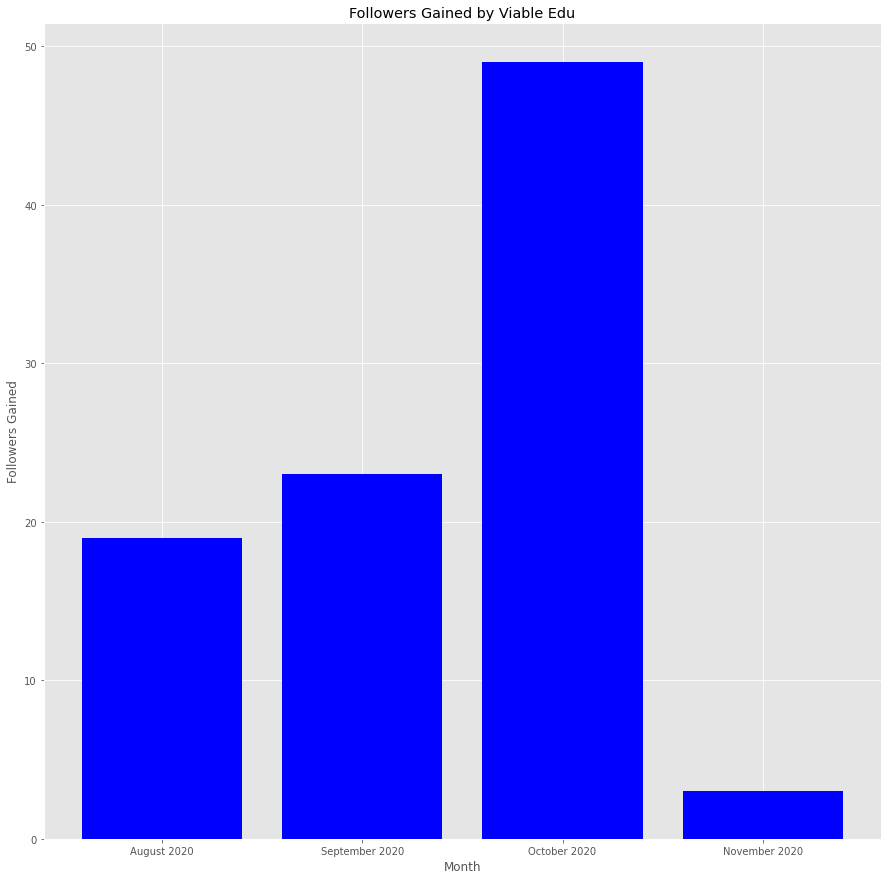

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,15))
plt.style.use('ggplot')

x = ['August 2020', 'September 2020', 'October 2020', 'November 2020']
y = [19, 23, 49, 3]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='blue')
plt.xlabel("Month")
plt.ylabel("Followers Gained")
plt.title("Followers Gained by Viable Edu")

plt.xticks(x_pos, x)

plt.show()
        

_**Note: This data is recorded as of November 5th, 2020_

In [83]:
experience_count = followers.groupby('Experience',operations={'count':turicreate.aggregate.COUNT()}).sort('count',ascending=False)

In [84]:
experience_counts

Experience,count
Student / Intern,36
Senior-level,15
Mid-level,25
Executive,12
Entry-level,6


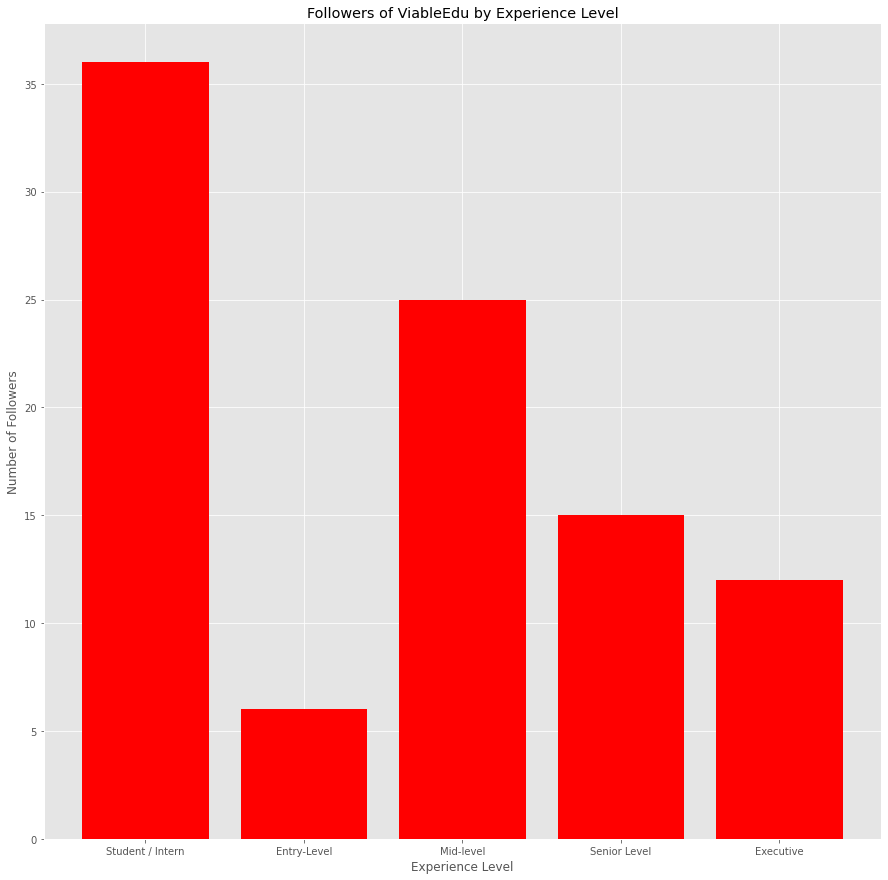

In [97]:
plt.figure(figsize=(15,15))
plt.style.use('ggplot')
x = ['Student / Intern', 'Entry-Level', 'Mid-level', 'Senior Level', 'Executive']
y = [36, 6, 25, 15, 12]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='red')
plt.xlabel("Experience Level")
plt.ylabel("Number of Followers")
plt.title("Followers of ViableEdu by Experience Level")

plt.xticks(x_pos, x)

plt.show()


In [93]:
industry_counts = followers.groupby('Industry',operations={'count':turicreate.aggregate.COUNT()}).sort('count',ascending=False)

In [94]:
industry_counts

Industry,count
Finance,50
Business and Consulting,30
Engineering & Technology,7
Academic / Research,5
Other,1
Law and Policy,1


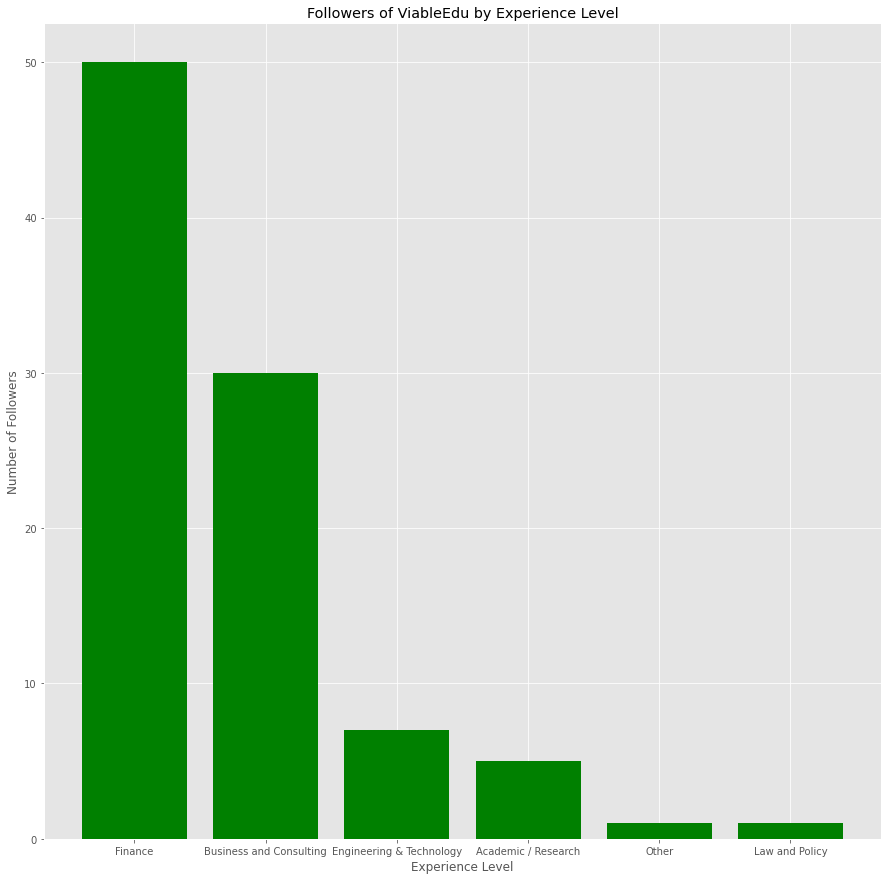

In [107]:
plt.figure(figsize=(15,15))
plt.style.use('ggplot')
x = list(industry_counts['Industry'])
y = list(industry_counts['count'])

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("Experience Level")
plt.ylabel("Number of Followers")
plt.title("Followers of ViableEdu by Experience Level")

plt.xticks(x_pos, x)

plt.show()


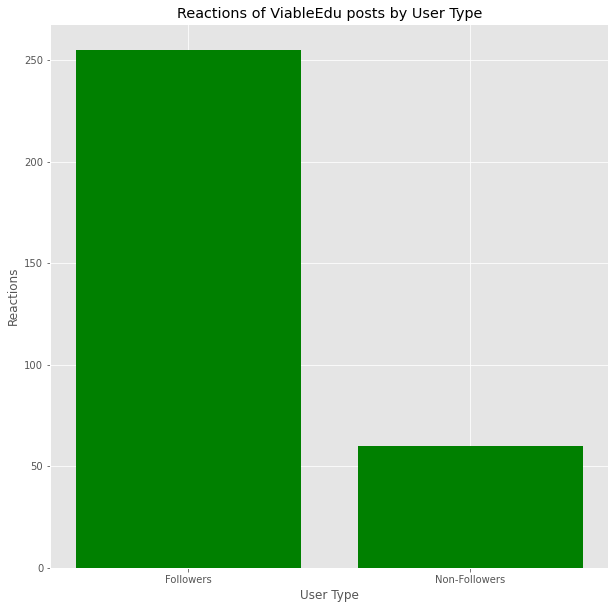

In [109]:
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
x = ['Followers', 'Non-Followers']
y = [follow, non_follow]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("User Type")
plt.ylabel("Reactions")
plt.title("Reactions of ViableEdu posts by User Type")

plt.xticks(x_pos, x)

plt.show()


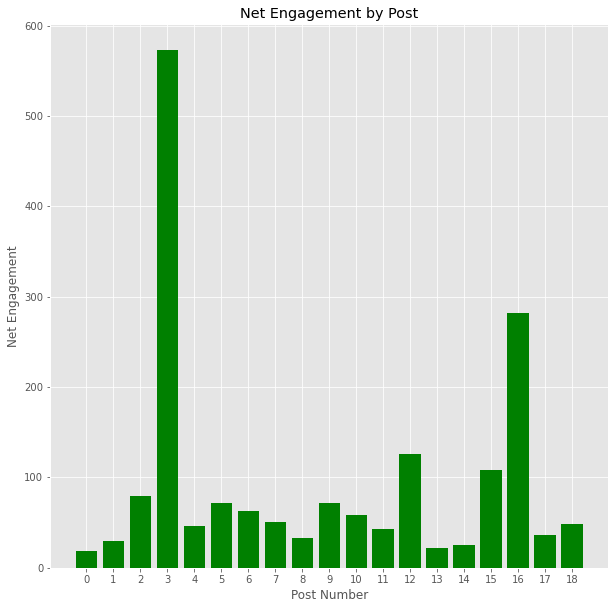

In [139]:
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
x = list(posts['postNmbr'])
y = list(posts['Net Engagement'])

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("Post Number")
plt.ylabel("Net Engagement")
plt.title("Net Engagement by Post")

plt.xticks(x_pos, x)

plt.show()


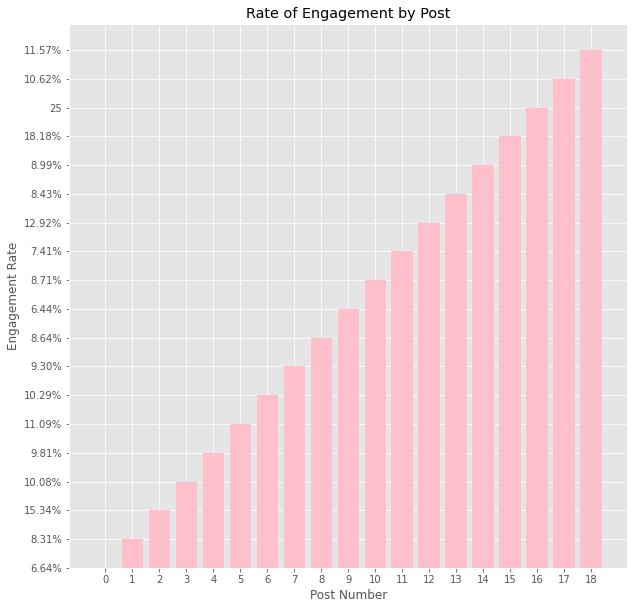

In [138]:
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
x = list(posts['postNmbr'])
y = list(posts['engagementRate'])

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='pink')
plt.xlabel("Post Number")
plt.ylabel("Engagement Rate")
plt.title("Rate of Engagement by Post")

plt.xticks(x_pos, x)

plt.show()


# Step 4: Derive Business Insights Based on Data